In [14]:
import json
import torch
import torch.nn.functional as F
import os
import sys
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm
from pathlib import Path
from loguru import logger
from importlib import reload

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

os.chdir('/home/nico/dev/projects/ai/musai/notebooks')

sys.path.append('../tools')

import tokenizer

reload(tokenizer)

TOKENS_PATH = '/home/nico/data/ai/models/midi/tiesto/bpe'
TOKENS_FILE_PATHS = list(Path(TOKENS_PATH).glob('*.json'))

In [2]:
device

device(type='cpu')

In [3]:
TOKENIZER = tokenizer.get_tokenizer(params=f'{TOKENS_PATH}/{tokenizer.TOKEN_PARAMS_NAME}')
PITCHES = [v for k, v in TOKENIZER.vocab.items() if 'Pitch' in k]

2023-06-02 20:49:45.996 | INFO     | tokenizer:get_tokenizer:237 - Tokenizer initialized. Using MMM


In [4]:
logger.info('Semantical processing: {collection_size} documents', collection_size=len(
    TOKENS_FILE_PATHS))

bag_of_hists = []

for token_file in tqdm(list(TOKENS_FILE_PATHS)):
    try:
        tokens = json.load(open(token_file, 'r'))['ids']

        # filter tokens
        tokens = [t for t in tokens if t in PITCHES]
        
        # extract pitch histogram
        tensor = torch.tensor(tokens).to(torch.float)
        tensor_hist = tensor.histc(bins=len(PITCHES))

        bag_of_hists.append(tensor_hist)
    except KeyboardInterrupt:
        break
    except Exception as e:
        logger.error(e)

bag_of_hists = torch.stack(bag_of_hists)
bag_of_hists_normalized = F.normalize(bag_of_hists, dim=0)


2023-06-02 20:49:49.331 | INFO     | __main__:<module>:1 - Semantical processing: 28 documents
100%|██████████| 28/28 [00:00<00:00, 1110.24it/s]


In [5]:
pitches_m = torch.stack([torch.mean(v) for v in bag_of_hists_normalized.t()])
distances = torch.FloatTensor([torch.mean((v - pitches_m) ** 2).item()
             for v in bag_of_hists_normalized])

distances

tensor([0.0053, 0.0055, 0.3194, 0.0143, 0.0223, 0.0124, 0.0035, 0.0249, 0.0423,
        0.0186, 0.0144, 0.0076, 0.0195, 0.0164, 0.0396, 0.0249, 0.0033, 0.0157,
        0.0061, 0.0172, 0.1054, 0.0285, 0.0084, 0.0783, 0.0029, 0.0091, 0.0154,
        0.0147])

In [11]:
TOKENS_FILE_PATHS[2]

PosixPath('/home/nico/data/ai/models/midi/tiesto/bpe/120_tiesto_forevertoday_anonymous_20130127202713_mid.json')

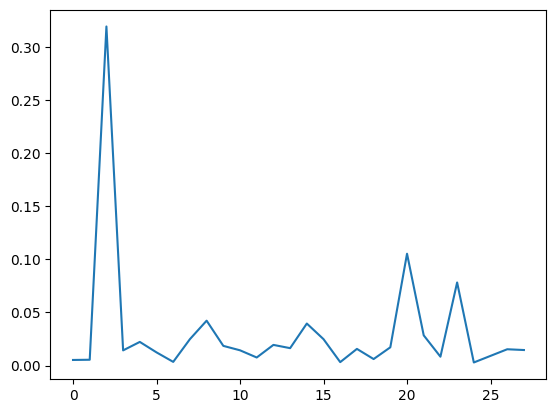

In [12]:
plt.plot(distances)